# IBM Quantum Awards: Open Science Prize 2022 Submission
## Calculating the highly frustrated ground state of a Heisenberg spin-1/2 model on a Kagome lattice using the Variational Quantum Eigensolver (VQE) algorithm

### Authors: 
- Clément Boisson
- Irene de León

### Attached files: 
- *our_method.pdf*: a description of our method (will be referenced as "the pdf file" later in the notebook)
- *heavy_hex_kagome_estimator.py*: a custom estimator based on qiskit sampler primitive

### Table of contents: 
- 1. Import librairies
- 2. Define the layout
- 3. Define the ansatz
- 4. Define the VQE
- 5. Configure the backend
- 6. Launch the algorithm
- 7. Results

In this notebook we calculate the ground state on a Kagome Lattice using the VQE algorithm using a method based on the Hamiltonian Variational Ansatz, and with a custom expectation value estimation method that use ancilla qubits.

*We hope that you will enjoy reading and testing our method as much as we did developping it!*

# 1. Import libraries

In [1]:
# Usual librairies:
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
import random
import math
import json
import datetime
import logging
import signal
import time

In [2]:
# Qiskit librairies
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit import IBMQ
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeGuadalupe
from qiskit.providers import JobStatus
from qiskit_ibm_runtime import Options, Session, QiskitRuntimeService
from qiskit_ibm_runtime import Sampler as RuntimeSampler
from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit.algorithms.optimizers import SPSA
print(qiskit.__qiskit_version__)

{'qiskit-terra': '0.23.2', 'qiskit-aer': '0.11.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.40.0', 'qiskit-nature': '0.5.2', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


In [3]:
# Our custom estimator
from heavy_hex_kagome_estimator import HeavyHexKagomeEstimator as HeavyHexKagomeEstimator

# 2. Define the layout

In [4]:
# List of connected physical qubits in the Guadalupe
# Qubit numbering is the device numbering used by IBM
# (see https://quantum-computing.ibm.com/services/resources?system=ibmq_guadalupe)
device_edges = [
    (0, 1),
    (1, 2),
    (2, 3),
    (3, 5),
    (5, 8),
    (8, 9),
    (8, 11),
    (11, 14),
    (13, 14),
    (12, 13),
    (12, 15),
    (10, 12),
    (7, 10),
    (6, 7),
    (4, 7),
    (1, 4)
]

In [5]:
# The layout that we used in our method, as a list of Kagome triangles
# Each triangle uses 3 main physical qubits, and some of them have a 4th physical qubit that we call "control qubit"
# The numbering used is the device qubit numbering. 
kagome_triangles = [
    {"kagome": (0, 2, 4), "control": 1},
    {"kagome": (4, 6, 10), "control": 7},
    {"kagome": (10, 13, 15), "control": 12},
    {"kagome": (11, 13, 14), "control": None},
    {"kagome": (5, 9, 11), "control": 8},
    {"kagome": (2, 3, 5), "control": None},
]

Here is the layout that we use (for more details, please see the "Layout" section in the pdf file): 

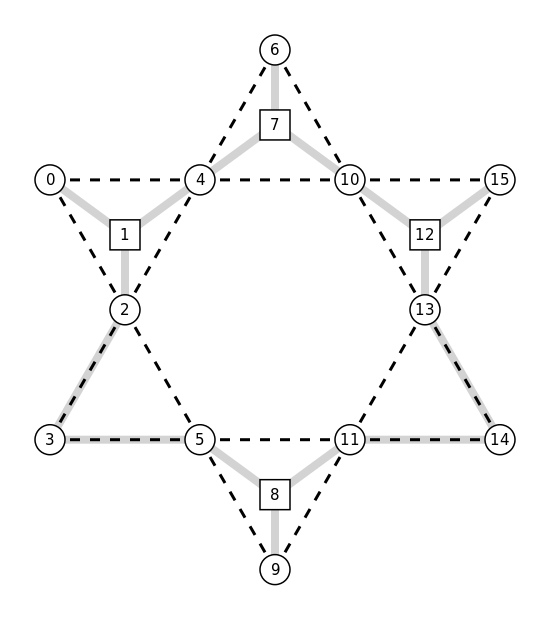

Legend:
- the grey lines represent the connection between 2 device qubits. 
- the dashed black lines represent the edges in the Kagome lattice. 
- circled vertices are device qubits that map directly to Kagome lattice vertices.
- squared vertices are device qubits that we use as "control" qubits.

In [6]:
# Define an instance of our custom estimator:
heavy_hex_kagome_estimator = HeavyHexKagomeEstimator(device_edges=device_edges, kagome_triangles=kagome_triangles)

# 3. Define the ansatz
The ansatz consists in preparing a ground state for 6 edges taken individually, some with a control qubit (green), some without (blue). Depending on the edge, we use a circuit or another: top right for green edges, bottom right for blue edges:

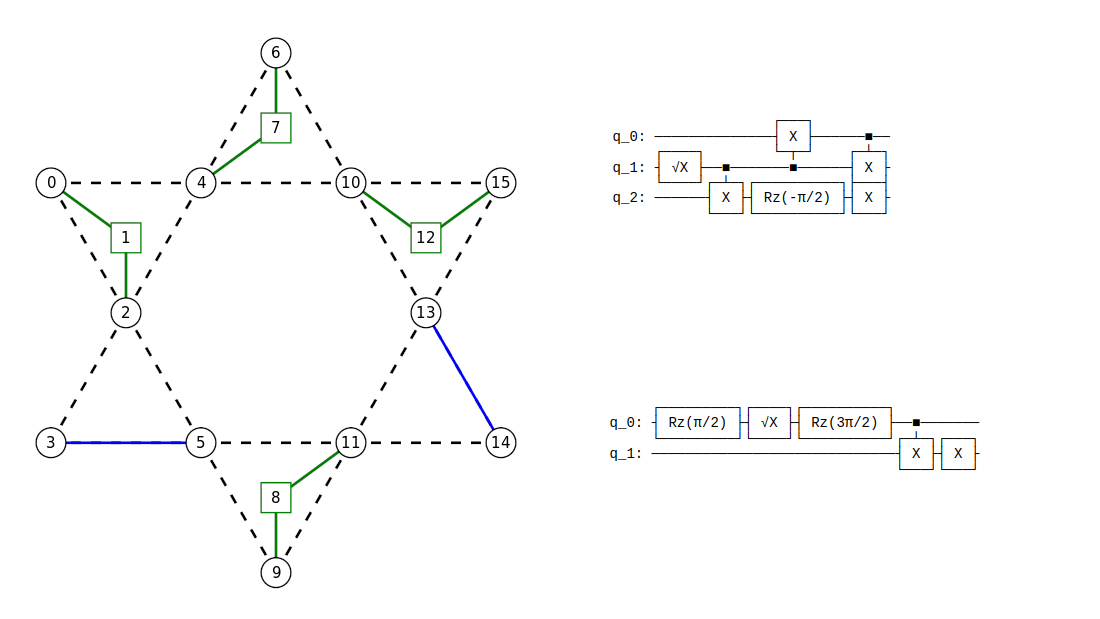

In addition to this basic circuit, we use some parameterized Rz gates to optimize the energy with the VQE optimizer. See the "Hamiltonian Variational Ansatz" section in the pdf file for more details.

The ansatz used here is a parameterized circuit with 6 real parameters. The *circuit_maker* function creates a quantum circuit for a given parameters set.

In [7]:
# Function that creates a quantum circuit given a set of parameters
# Please see the "Layout" and "Hamiltonian Variational Ansatz" sections in the attached pdf file.
def circuit_maker(parameters):
    circ = QuantumCircuit(16, 16)

    # The 4 triangles that have a control qubit
    # with edge = [vertex1, control qubit, vertex2]
    for edge_idx, edge in enumerate([
        [2, 1, 0], 
        [4, 7, 6], 
        [10, 12, 15],
        [11, 8, 9]
    ]):
        circ.sx(edge[1])
        circ.cx(edge[1], edge[2])
        circ.cx(edge[1], edge[0])
        circ.rz(-math.pi/2.0 + parameters[edge_idx], edge[2]) # This gate is parameterized
        circ.cx(edge[0], edge[1])
        circ.x(edge[2])

    # The 2 triangles that don't have a control qubit
    # with edge = [vertex1, vertex2]
    for edge_idx, edge in enumerate([
        [13, 14],
        [5, 3]
    ]):
        circ.rz(math.pi/2, edge[0])
        circ.sx(edge[0])
        circ.rz(3*math.pi/2 + parameters[4+edge_idx], edge[0]) # This gate is parameterized
        circ.cx(edge[0], edge[1])
        circ.x(edge[1])
        
    return circ

In [8]:
# Here is an example with all parameters set to 0. 
# In a noiseless environment, this circuit prepares a ground state of the XXX-Heisenberg hamiltonian
circuit_maker(np.zeros(6)).draw()

┌───┐ ┌──────────┐   ┌───┐                   
 q_0: ───────────┤ X ├─┤ Rz(-π/2) ├───┤ X ├───────────────────
         ┌────┐  └─┬─┘ └──────────┘   ├───┤                   
 q_1: ───┤ √X ├────■────────■─────────┤ X ├───────────────────
         └────┘           ┌─┴─┐       └─┬─┘                   
 q_2: ────────────────────┤ X ├─────────■─────────────────────
                          └───┘                     ┌───┐┌───┐
 q_3: ──────────────────────────────────────────────┤ X ├┤ X ├
                          ┌───┐                     └─┬─┘└───┘
 q_4: ────────────────────┤ X ├──────────────────■────┼───────
      ┌─────────┐┌────┐   └─┬─┘    ┌──────────┐  │    │       
 q_5: ┤ Rz(π/2) ├┤ √X ├─────┼──────┤ Rz(3π/2) ├──┼────■───────
      └─────────┘├───┬┘     │      ├──────────┤  │  ┌───┐     
 q_6: ───────────┤ X ├──────┼──────┤ Rz(-π/2) ├──┼──┤ X ├─────
         ┌────┐  └─┬─┘      │      └──────────┘┌─┴─┐└───┘     
 q_7: ───┤ √X ├────■────────■──────────────────┤ X ├──────────
         ├────┤                                └───┘┌───┐     
 q_8: ───┤ √X ├────■────────────────────■───────────┤ X ├─────
         └────┘  ┌─┴─┐ ┌──────────┐     │      ┌───┐└─┬─┘     
 q_9: ───────────┤ X ├─┤ Rz(-π/2) ├─────┼──────┤ X ├──┼───────
                 └───┘ └──┬───┬───┘     │      └───┘  │       
q_10: ────────────────────┤ X ├─────────┼────────■────┼───────
                          └─┬─┘       ┌─┴─┐      │    │       
q_11: ──────────────────────┼─────────┤ X ├──────┼────■───────
         ┌────┐             │         └───┘    ┌─┴─┐          
q_12: ───┤ √X ├────■────────■──────────────────┤ X ├──────────
      ┌──┴────┴─┐  │      ┌────┐   ┌──────────┐└───┘          
q_13: ┤ Rz(π/2) ├──┼──────┤ √X ├───┤ Rz(3π/2) ├──■────────────
      └─────────┘  │      └────┘   └──────────┘┌─┴─┐┌───┐     
q_14: ─────────────┼───────────────────────────┤ X ├┤ X ├─────
                 ┌─┴─┐ ┌──────────┐   ┌───┐    └───┘└───┘     
q_15: ───────────┤ X ├─┤ Rz(-π/2) ├───┤ X ├───────────────────
                 └───┘ └──────────┘   └───┘                   
c: 16/════════════════════════════════════════════════════════

# 4. Define the VQE

In [9]:
# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, heavy_hex_kagome_estimator, sampler, callback, calib_num_twirled_circuits, calib_shots, num_twirled_circuits, shots):
        self.heavy_hex_kagome_estimator = heavy_hex_kagome_estimator
        self.sampler = sampler
        self.callback = callback
        # Number of twirled circuits and number of shots for calibration and during optimization
        self.calib_num_twirled_circuits = calib_num_twirled_circuits
        self.calib_shots = calib_shots
        self.num_twirled_circuits = num_twirled_circuits
        self.shots = shots
        
    def compute_minimum_eigenvalue(self, circuit_maker, num_parameters):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Create the base circuit with the parameters
            parameterized_circuit = circuit_maker(x)
            # Execute the job and compute the estimations
            results = self.heavy_hex_kagome_estimator.estimate_energy_for_circuit(
                base_circuit=parameterized_circuit, 
                sampler=self.sampler, # The qiskit sampler primitive to use
                num_twirled_circuits=self.num_twirled_circuits, # Number of twirled circuits for the T-REx algorithm
                shots=self.shots # Number of shots per circuit
            )
            # Save result information using callback function
            if self.callback is not None:
                self.callback({
                    "x": x.tolist(),
                    "results": results
                })
            # Return the estimated energy
            return results["energy"]
        
        # Calibrate
        print(str(datetime.datetime.now()) + ": Starting calibration")
        self.heavy_hex_kagome_estimator.calibrate(
            sampler=self.sampler, # The qiskit sampler primitive to use
            num_twirled_circuits=self.calib_num_twirled_circuits, # Number of twirled circuits for the T-REx algorithm
            shots=self.calib_shots # Number of shots per circuit
        )
        print(str(datetime.datetime.now()) + ": Calibration finished!")
        
        # Optimizer
        optimizer = SPSA(maxiter=500)
        
        # Select an initial point for the ansatzs' parameters (+- PI/8 around 0)
        x0 = np.random.rand(num_parameters) * math.pi/4.0 - math.pi/8
        
        # Run optimization (we only look for parameters between -PI/4 and +PI/4)
        res = optimizer.minimize(objective, x0=x0, bounds=[(-math.pi/8, math.pi/8) for i in range(num_parameters)])
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

# 5. Configure the backend

### Sampler class to handle backend device
Highly inspired to the one given in the official notebook, but adapted to the Sampler primitive

In [10]:
def timeout_handler(signum, frame):
    raise Exception('Iteration timed out')

class RuntimeRetrySampler(RuntimeSampler):
    """RuntimeRetrySampler class.
    
    This class inherits from Qiskit IBM Runtime's Sampler and overwrites its run method such that it retries calling it
    a maximum of 'max_retries' consecutive times, if it encounters one of the following randomly occuring errors:
    
    * An Sampler error (in this case "Job.ERROR" is printed, and the job is cancelled automatically)
    * A timeout error where the job either remains running or completes but does not return anything, for a time larger 
      than 'timeout' (in this case the job is cancelled by the patch and "Job.CANCELLED" is printed)
    * A creation error, where the job fails to be created because connection is lost between the runtime server and the
      quantum computer (in this case "Failed to create job." is printed). If this error occurs, the patch connects the user
      to a new Session (to be handled with care! also, this will unfortunately put the next job in the queue). 
    """
    
    def __init__(self, options, session, max_retries: int = 5, timeout: int = 3600) -> None:
        super().__init__(options=options, session=session)
        self.max_retries = max_retries
        self.timeout = timeout
        self.backend = super().session._backend
        signal.signal(signal.SIGALRM, timeout_handler)
    
    def run(self, circuits, parameter_values, shots):
        result = None
        for i in range(self.max_retries):
            
            job = super().run(circuits, parameter_values, shots=shots)
            while job.status() in [JobStatus.INITIALIZING, JobStatus.QUEUED, JobStatus.VALIDATING]:
                time.sleep(5) # Check every 5 seconds whether job status has changed
            signal.alarm(self.timeout) # Once job starts running, set timeout to 1 hour by default
            result = job.result()
            if result is not None:
                signal.alarm(0) # reset timer
                return job
            
            try:
                print("test")
            except Exception as e:
                print("\nSomething went wrong...")
                print(f"\n\nERROR MESSAGE:\n{e}\n\n")
                if 'job' in locals(): # Sometimes job fails to create
                    print(f"Job ID: {job.job_id}. Job status: {job.status()}.")
                    if job.status() not in [JobStatus.DONE, JobStatus.ERROR, JobStatus.CANCELLED]:
                        job.cancel()
                else:
                    print("Failed to create job.")
                print(f"Starting trial number {i+2}...\n")
                print(f"Creating new session...\n")
                signal.alarm(0) # reset timer
                super().session.close()
                self._session = Session(backend=self.backend)
        if result is None:
            raise RuntimeError(f"Program failed! Maximum number of retries ({self.max_retries}) exceeded")

### Noisy simulator *(skip this part!)*

In [19]:
# Get noise model
fake_guadalupe = FakeGuadalupe()
noise_model = NoiseModel.from_backend(fake_guadalupe)

# Set options to include noise_model, and disable optimization and resilience handled natively by qiskit
options = Options(simulator={ 
    "noise_model": noise_model
}, optimization_level=0, resilience_level=0)

# Choose the noisy simulator as backend
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-community/ibmquantumawards/open-science-22',
)
backend = service.backend("ibmq_qasm_simulator")

# Define instance of Sampler primitive
qiskit_raw_sampler = RuntimeRetrySampler(options=options, session=backend)

### Actual IBMQ Guadalupe device

In [ ]:
# Set options to disable optimization and resilience handled natively by qiskit
options = Options(optimization_level=0, resilience_level=0)

# Load IBMQ account
IBMQ.load_account() # Load account from disk

# Choose the real backend
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-community/ibmquantumawards/open-science-22',
)
backend = service.backend("ibmq_guadalupe")

# Define instance of Sampler primitive
qiskit_raw_sampler = RuntimeRetrySampler(options=options, session=backend)

# 6. Launch the algorithm

In [20]:
# Define a simple callback function
intermediate_info = []
def callback(value):
    intermediate_info.append(value)
    print("{}. Current value: {}".format(datetime.datetime.now(), value["results"]["energy"]))

In [ ]:
# Setup VQE algorithm
custom_vqe = CustomVQE(
    heavy_hex_kagome_estimator = heavy_hex_kagome_estimator, 
    sampler = qiskit_raw_sampler, 
    callback = callback,
    calib_num_twirled_circuits = 16, # Number of twirled circuits during the calibration phase
    calib_shots = 4000, # Number of shots per circuit during the calibration phase
    num_twirled_circuits = 8, # Number of twirled circuits
    shots = 512 # Number of shots
)

# Run the custom VQE function and monitor execution time
start = time.time()
result = custom_vqe.compute_minimum_eigenvalue(circuit_maker, 6)
end = time.time()

print(result)
print(f'execution time (s): {end - start:.2f}')

# 7. Results
Unfortunately, we didn't manage to get results with the real Guadalupe device (9999 errors) and we had trouble using the ibmq_qasm_simulator as well. However, we show here below an example of a run of the algorithm with the noisy simulator, until the simulator cluster apparently went down:

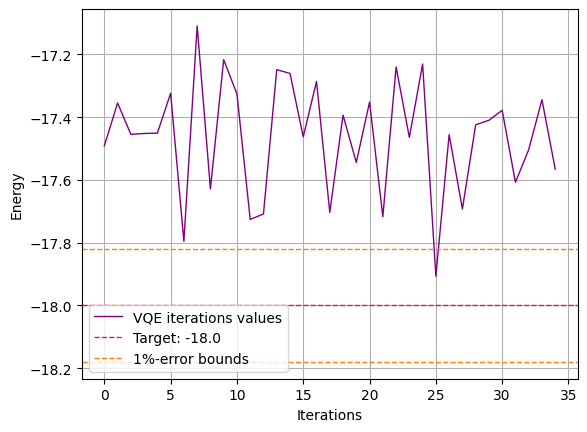

In [24]:
plt.plot([ite["results"]["energy"] for ite in intermediate_info], color='purple', lw=1)
plt.axhline(y=-18, color="tab:red", ls="--", lw=1, label="Target: -18.0")
plt.axhline(y=-18*0.99, color="tab:orange", ls="--", lw=1)
plt.axhline(y=-18*1.01, color="tab:orange", ls="--", lw=1)
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.legend(["VQE iterations values", "Target: -18.0", "1%-error bounds"])
plt.grid()
plt.show()

In [34]:
# Compute the minimum energy value found, and its relative error percentage:
def rel_err_pct(target, measured):
    return round(100.0*abs((target - measured) / target), 2) 

minimum_energy = np.min([ite["results"]["energy"] for ite in intermediate_info])

print("Minimal energy found: {}".format(minimum_energy))
print("Relative error: {}%".format(rel_err_pct(-18.0, minimum_energy)))

Minimal energy found: -17.906847156401483
Relative error: 0.52%
